In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
imported_data =[]
for i in range(1,32):
    imported_data.append(pd.read_csv(f'./dds_datasets/dds_ch2_nyt/nyt{i}.csv'))
data_frame = pd.concat(imported_data, ignore_index=True)

data_frame

,Age,Gender,Impressions,Clicks,Signed_In
0,36,0,3,0,1
1,73,1,3,0,1
2,30,0,3,0,1
3,49,1,3,0,1
4,47,1,11,0,1
...,...,...,...,...,...
14905860,41,1,4,0,1
14905861,0,0,5,0,0
14905862,22,1,3,0,1
14905863,59,0,5,1,1


In [3]:
# Визначаємо діапазони віку
bins = [0, 18, 24, 34, 44, 54, 64, float('inf')]
labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Додаємо новий стовпець "age_group"
data_frame['age_group'] = pd.cut(data_frame['Age'], bins=bins, labels=labels, right=False)

# Виводимо перші рядки для перевірки результату
print(data_frame.head())

   Age  Gender  Impressions  Clicks  Signed_In age_group
0   36       0            3       0          1     35-44
1   73       1            3       0          1       65+
2   30       0            3       0          1     25-34
3   49       1            3       0          1     45-54
4   47       1           11       0          1     45-54


In [4]:
# data_frame['CTR']=data_frame['Clicks'] / data_frame['Impressions']
# print(data_frame.head())

# filtered_data = data_frame[data_frame['CTR'] > 0]
# print(filtered_data)

In [5]:
grouped_data = data_frame.groupby(['age_group','Gender']).agg({'Clicks': 'sum', 'Impressions': 'sum'}).reset_index()
grouped_data['CTR']=grouped_data['Clicks'] / grouped_data['Impressions']

grouped_data

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\448071946.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_frame.groupby(['age_group','Gender']).agg({'Clicks': 'sum', 'Impressions': 'sum'}).reset_index()


,age_group,Gender,Clicks,Impressions,CTR
0,<18,0,815692,28716727,0.028405
1,<18,1,40964,1373095,0.029833
2,18-24,0,28547,2567289,0.011120
3,18-24,1,31854,2851414,0.011171
4,25-34,0,39757,3960583,0.010038
5,25-34,1,44078,4403825,0.010009
6,35-44,0,48064,4784496,0.010046
7,35-44,1,53184,5328839,0.009980
8,45-54,0,44851,4428835,0.010127
9,45-54,1,49126,4915835,0.009993


C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\627181326.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'


<Figure size 500x300 with 0 Axes>

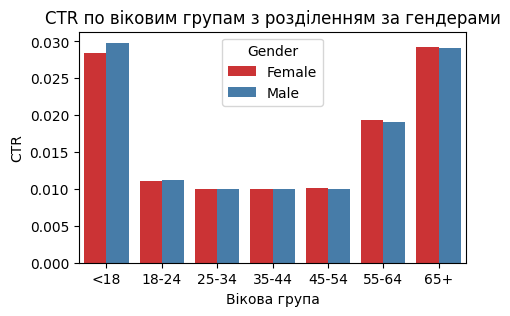

In [6]:
# Побудова графіку
grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'
plt.figure(figsize=(5, 3))
# plt.bar(grouped_data['age_group'], grouped_data['CTR'], label='CTR')

# # Додавання заголовку та легенди
# plt.xlabel('Вікова група')
# plt.ylabel('Значення')
# plt.title('CTR за віковими групами')
# plt.legend()

# # Відображення графіку
# plt.show()

plt.figure(figsize=(5, 3))
sns.barplot(x='age_group', y='CTR', hue='Gender', data=grouped_data, palette='Set1')
plt.title('CTR по віковим групам з розділенням за гендерами')
plt.xlabel('Вікова група')
plt.ylabel('CTR')
plt.show()

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\2792835753.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_data.loc[filtered_data['Gender'] == 1, 'Gender'] = 'Male'


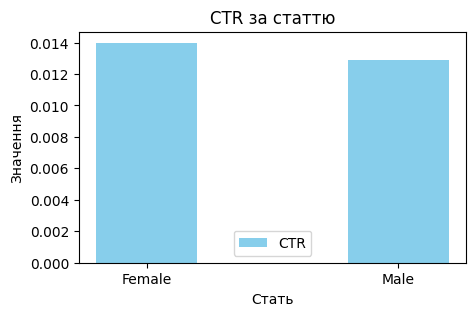

In [7]:
filtered_data = data_frame[data_frame['Age'] > 18]
filtered_data.loc[filtered_data['Gender'] == 1, 'Gender'] = 'Male'
filtered_data.loc[filtered_data['Gender'] == 0, 'Gender'] = 'Female'
grouped_data = filtered_data.groupby('Gender').agg({'Clicks': 'sum', 'Impressions': 'sum'}).reset_index()
grouped_data['CTR']=grouped_data['Clicks'] / grouped_data['Impressions']

plt.figure(figsize=(5, 3))
plt.bar(grouped_data['Gender'], grouped_data['CTR'], label='CTR',color='skyblue', width=0.4)

plt.xlabel('Стать')
plt.ylabel('Значення')
plt.title('CTR за статтю')
plt.legend()

plt.show()

In [8]:
grouped_data = data_frame.groupby(['age_group', 'Signed_In'],observed='False').agg({'Impressions': 'sum', 'Clicks': 'sum'}).reset_index()
grouped_data['CTR']=grouped_data['Clicks'] / grouped_data['Impressions']

grouped_data

,age_group,Signed_In,Impressions,Clicks,CTR
0,<18,0,28074662,796448,0.028369
1,<18,1,2015160,60208,0.029878
2,18-24,1,5418703,60401,0.011147
3,25-34,1,8364408,83835,0.010023
4,35-44,1,10113335,101248,0.010011
5,45-54,1,9344670,93977,0.010057
6,55-64,1,6650349,127848,0.019224
7,65+,1,4540781,132803,0.029247


In [9]:
filtered_data = data_frame[data_frame['Age'] > 18]
filtered_data
filtered_data = filtered_data[filtered_data['Signed_In'] == 0]
filtered_data

,Age,Gender,Impressions,Clicks,Signed_In,age_group


C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\3917430447.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_frame.groupby(['age_group','Gender']).agg({'Clicks': 'sum', 'Impressions': 'sum'}).reset_index()
C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\3917430447.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'


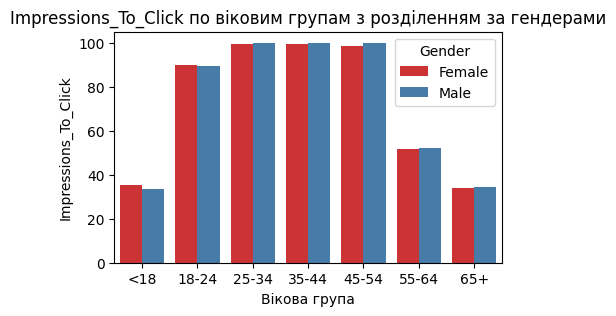

In [10]:
grouped_data = data_frame.groupby(['age_group','Gender']).agg({'Clicks': 'sum', 'Impressions': 'sum'}).reset_index()
grouped_data['Impressions_To_Click']=grouped_data['Impressions'] / grouped_data['Clicks']

grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'
# Побудова графіку
plt.figure(figsize=(5, 3))
sns.barplot(x='age_group', y='Impressions_To_Click', hue='Gender', data=grouped_data, palette='Set1')
plt.title('Impressions_To_Click по віковим групам з розділенням за гендерами')
plt.xlabel('Вікова група')
plt.ylabel('Impressions_To_Click')
plt.show()

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\3049819653.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_frame.groupby(['age_group','Gender'])['Impressions'].median().reset_index()
C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\3049819653.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'


<Figure size 500x300 with 0 Axes>

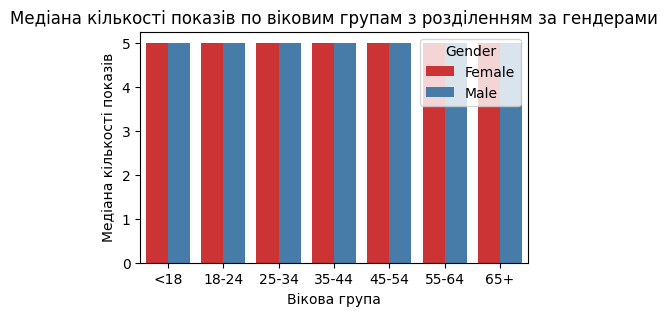

In [11]:
grouped_data = data_frame.groupby(['age_group','Gender'])['Impressions'].median().reset_index()

# Побудова графіку
grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'
plt.figure(figsize=(5, 3))
# plt.bar(grouped_data['age_group'], grouped_data['CTR'], label='CTR')

plt.figure(figsize=(5, 3))
sns.barplot(x='age_group', y='Impressions', hue='Gender', data=grouped_data, palette='Set1')
plt.title('Медіана кількості показів по віковим групам з розділенням за гендерами')
plt.xlabel('Вікова група')
plt.ylabel('Медіана кількості показів')
plt.show()

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\3560859285.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_frame.groupby(['age_group','Gender'])['Clicks'].mean().reset_index()
C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\3560859285.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'


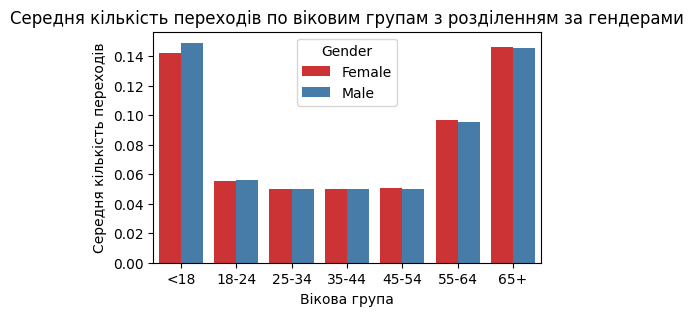

In [12]:
grouped_data = data_frame.groupby(['age_group','Gender'])['Clicks'].mean().reset_index()
# Побудова графіку
grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'
# plt.bar(grouped_data['age_group'], grouped_data['CTR'], label='CTR')

plt.figure(figsize=(5, 3))
sns.barplot(x='age_group', y='Clicks', hue='Gender', data=grouped_data, palette='Set1')
plt.title('Середня кількість переходів по віковим групам з розділенням за гендерами')
plt.xlabel('Вікова група')
plt.ylabel('Середня кількість переходів')
plt.show()

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\2434265605.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_frame.groupby(['age_group','Gender'])['Clicks'].max().reset_index()
C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\2434265605.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'


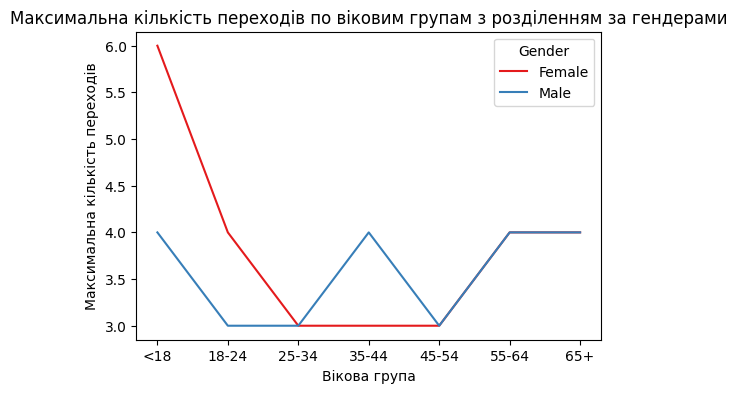

In [13]:
grouped_data = data_frame.groupby(['age_group','Gender'])['Clicks'].max().reset_index()
# Побудова графіку
grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'
# plt.bar(grouped_data['age_group'], grouped_data['CTR'], label='CTR')

plt.figure(figsize=(6, 4))
sns.lineplot(x='age_group', y='Clicks', hue='Gender', data=grouped_data, palette='Set1')
plt.title('Максимальна кількість переходів по віковим групам з розділенням за гендерами')
plt.xlabel('Вікова група')
plt.ylabel('Максимальна кількість переходів')
plt.show()

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\1888159345.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_frame.groupby(['age_group','Gender'])['Impressions'].var().reset_index(name='dispersion')
C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\1888159345.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'


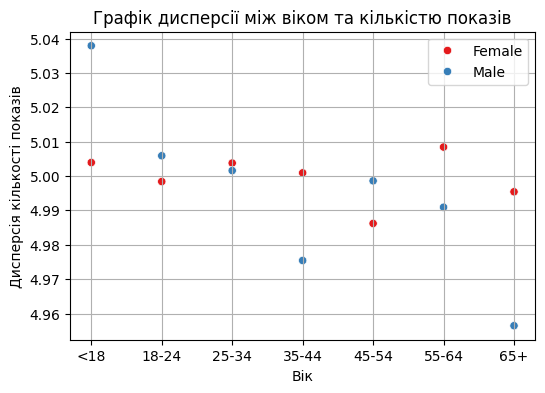

In [14]:
grouped_data = data_frame.groupby(['age_group','Gender'])['Impressions'].var().reset_index(name='dispersion')
grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'
plt.figure(figsize=(6, 4))
sns.scatterplot(x='age_group', y='dispersion', hue='Gender', data=grouped_data, palette='Set1')
# sns.scatterplot(grouped_data['age_group'], grouped_data['dispersion'],hue='Gender', color='b', marker='o')
plt.title('Графік дисперсії між віком та кількістю показів')
plt.xlabel('Вік')
plt.ylabel('Дисперсія кількості показів')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\2107172605.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_frame.groupby(['age_group','Gender'])['Clicks'].var().reset_index(name='dispersion')
C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\2107172605.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'


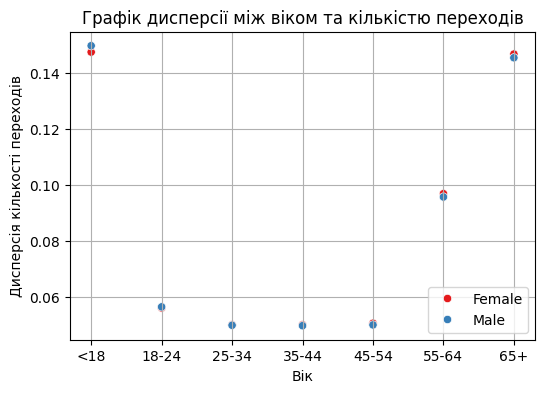

In [15]:
grouped_data = data_frame.groupby(['age_group','Gender'])['Clicks'].var().reset_index(name='dispersion')
grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'
plt.figure(figsize=(6, 4))
sns.scatterplot(x='age_group', y='dispersion', hue='Gender', data=grouped_data, palette='Set1')
# sns.scatterplot(grouped_data['age_group'], grouped_data['dispersion'],hue='Gender', color='b', marker='o')
plt.title('Графік дисперсії між віком та кількістю переходів')
plt.xlabel('Вік')
plt.ylabel('Дисперсія кількості переходів')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\42558314.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Male' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
C:\Users\vitte\AppData\Local\Temp\ipykernel_16904\42558314.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Signed' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_data.loc[grouped_data['Signed_In'] == 1, 'Signed_In'] = 'Signed'


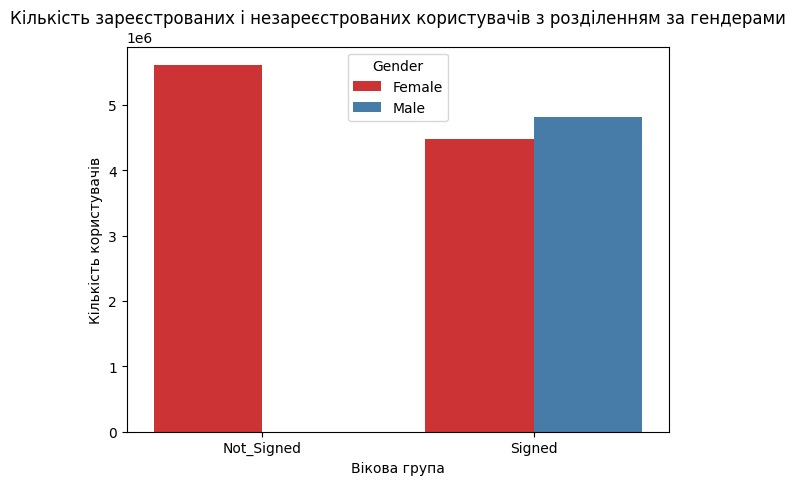

In [16]:
grouped_data = data_frame.groupby(['Gender','Signed_In'],observed='False').size().reset_index(name='Count')
grouped_data.loc[grouped_data['Gender'] == 1, 'Gender'] = 'Male'
grouped_data.loc[grouped_data['Gender'] == 0, 'Gender'] = 'Female'

grouped_data.loc[grouped_data['Signed_In'] == 1, 'Signed_In'] = 'Signed'
grouped_data.loc[grouped_data['Signed_In'] == 0, 'Signed_In'] = 'Not_Signed'

plt.figure(figsize=(7, 5))
sns.barplot(x='Signed_In', y='Count', hue='Gender', data=grouped_data, palette='Set1')
plt.title('Кількість зареєстрованих і незареєстрованих користувачів з розділенням за гендерами')
plt.xlabel('Вікова група')
plt.ylabel('Кількість користувачів')
plt.show()